 변수축으로 평균낸 변수 중요도(바차트)

CMP_Visualization 으로 넘기기
1. 오리지널 시그널 그래프
2. 변환된 시그널 그래프
3. MRR 분포 그래프
4. 성능 평가 시각화 코드 짜기



# 1. 기본 셋팅(라이브러리, 인풋데이터 로드)

In [1]:
# 필수 라이브러리
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score, mean_squared_error
import os
os.chdir('/content/drive/MyDrive/빅데이터분석연구실/연구작업')
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
# 회귀용 3그룹
DL_input1 = ['scaled_X_tr_A_low', 'scaled_X_te_A_low','y_tr_A_low','y_te_A_low',
             'scaled_X_tr_A_high', 'scaled_X_te_A_high', 'y_tr_A_high', 'y_te_A_high',
             'scaled_X_tr_B', 'scaled_X_te_B', 'y_tr_B', 'y_te_B']


Sensors=['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_POLISHING_TABLE',  'USAGE_OF_MEMBRANE', 'USAGE_OF_PRESSURIZED_SHEET', 
         'MAIN_OUTER_AIR_BAG_PRESSURE', 'PRESSURIZED_CHAMBER_PRESSURE', 'CENTER_AIR_BAG_PRESSURE', 'RIPPLE_AIR_BAG_PRESSURE', 'EDGE_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE',
        'SLURRY_FLOW_LINE_A', 'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C',
        'WAFER_ROTATION', 'STAGE_ROTATION', 'HEAD_ROTATION']


# 데이터 변수 지정
scaled_X_tr_A_low = np.load('./DL_input/{}.npy'.format(DL_input1[0]))
scaled_X_te_A_low = np.load('./DL_input/{}.npy'.format(DL_input1[1]))
y_tr_A_low = np.load('./DL_input/{}.npy'.format(DL_input1[2]))
y_te_A_low = np.load('./DL_input/{}.npy'.format(DL_input1[3]))

scaled_X_tr_A_high = np.load('./DL_input/{}.npy'.format(DL_input1[4]))
scaled_X_te_A_high = np.load('./DL_input/{}.npy'.format(DL_input1[5]))
y_tr_A_high = np.load('./DL_input/{}.npy'.format(DL_input1[6]))
y_te_A_high = np.load('./DL_input/{}.npy'.format(DL_input1[7]))

scaled_X_tr_B = np.load('./DL_input/{}.npy'.format(DL_input1[8]))
scaled_X_te_B = np.load('./DL_input/{}.npy'.format(DL_input1[9]))
y_tr_B = np.load('./DL_input/{}.npy'.format(DL_input1[10]))
y_te_B = np.load('./DL_input/{}.npy'.format(DL_input1[11]))



# 로드된 데이터 쉐잎 확인
data1 = [scaled_X_tr_A_low, scaled_X_tr_A_high, scaled_X_tr_B, scaled_X_te_A_low, scaled_X_te_A_high, scaled_X_te_B,
        y_tr_A_low, y_tr_A_high, y_tr_B, y_te_A_low, y_te_A_high, y_te_B]

for d1 in data1:
  print(d1.shape)

(798, 100, 18, 1)
(364, 100, 18, 1)
(815, 100, 18, 1)
(165, 100, 18, 1)
(73, 100, 18, 1)
(186, 100, 18, 1)
(798, 1)
(364, 1)
(815, 1)
(165, 1)
(73, 1)
(186, 1)


In [ ]:
# 파일이름과 테스트셋 데이터를 넣어 모델 로드
def Load_model(file_name, X_test, y_test):
  model = load_model('/content/drive/MyDrive/빅데이터분석연구실/논문작업/save_model/{}.h5'.format(file_name))
  # model.summary()
  return model

In [ ]:
# A_low_best = Load_model('new2_DeepConvLSTM_A_low_1_epoch1000_batch64', scaled_X_te_A_low, y_te_A_low)
A_high_best = Load_model('new2_DeepConvLSTM_A_high_1_epoch1000_batch32', scaled_X_te_A_high, y_te_A_high)
# B_best = Load_model('new2_DeepConvLSTM_B_1_epoch1000_batch64', scaled_X_te_B, y_te_B)

OSError: ignored

In [3]:
# 파일이름과 테스트셋 데이터를 넣어 모델 로드
def Load_model(file_name, X_test, y_test):
  model = load_model('/content/drive/MyDrive/빅데이터분석연구실/연구작업/save_model/final_model/{}.h5'.format(file_name))
  model.evaluate(X_test, y_test)
  # model.summary()
  return model

In [4]:
A_low_best = Load_model('DeepConvLSTM_A_low_1_epoch1000_batch64_mse7', scaled_X_te_A_low, y_te_A_low)
A_high_best = Load_model('DeepConvLSTM_A_high_1_epoch1000_batch32_mse10', scaled_X_te_A_high, y_te_A_high)
B_best = Load_model('DeepConvLSTM_B_1_epoch1000_batch64_mse13', scaled_X_te_B, y_te_B)

6/6 [==============================] - 2s 174ms/step - loss: 13.3430


# CAM 구현 코드


In [5]:
# Grad_CAM 생성 코드
def Build_Grad_CAM(inputs, y_test, model, last_conv_layer, idx):
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
  )

  with tf.GradientTape() as tape:
    f_k, y_k = grad_model(inputs)
  # f_k에 대한 y_k의 그래디언트
  grads = tape.gradient(y_k, f_k)
  # GAP로 그래디언트를 가중치화
  weights = tf.reduce_mean(grads, axis=(0,1,2))
  # 인스턴스 선택
  f_k = f_k[idx]
  pred = y_k[idx]
  true = y_test[idx]

  # 맵핑 시각화하기 위한 공간 초기화
  grad_cam = np.zeros(dtype=np.float32, shape=f_k.shape[:2])
  
  for k, w_k in enumerate(weights):
    grad_cam += np.abs(w_k) * f_k[:, :, k]

  # ReLU에 넣어 positive한 값만 산출
  grad_CAM = np.maximum(grad_cam, 0)

  return grad_CAM, pred, true

In [6]:
PV_idx = ['PV1', 'PV2', 'PV3', 'PV4', 'PV5', 'PV6', 'PV7', 'PV8', 'PV9', 'PV10', 'PV11', 'PV12', 'PV13', 'PV14', 'PV15', 'PV16', 'PV17', 'PV18']

def Plot_Grad_CAM(cam_output, pred_value, true_value, idx):
  plt.figure(figsize=(25,12))
  plt.title('{}th Wafer, '.format(idx+1)+'Pred_MRR : '+str(round(pred_value.numpy()[0], 4))+',  True_MRR : '+str(round(true_value[0], 4)), fontsize=15)
  plt.imshow(tf.reshape(np.array(cam_output).T, (18, cam_output.shape[0])), cmap='jet')
  y_ticks = PV_idx
  plt.yticks(np.arange(0, 18), y_ticks)
  plt.tick_params(axis='both', which='major', labelsize=13, left=False, labelleft=True)
  plt.show()

In [ ]:
A_low_best.summary()

Model: "DeepConvLstm_CAM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 18, 1)]      0         
                                                                 
 Conv_1 (Conv2D)             (None, 100, 18, 64)       384       
                                                                 
 Conv_2 (Conv2D)             (None, 100, 18, 64)       20544     
                                                                 
 Conv_3 (Conv2D)             (None, 100, 18, 64)       20544     
                                                                 
 Conv_4 (Conv2D)             (None, 100, 18, 64)       20544     
                                                                 
 Reshape (Reshape)           (None, 100, 1152)         0         
                                                                 
 LSTM_1 (LSTM)               (None, 100, 128)     

In [ ]:
for i in range(18):
  print(A_low_best.get_weights()[i].shape)

(5, 1, 1, 64)
(64,)
(5, 1, 64, 64)
(64,)
(5, 1, 64, 64)
(64,)
(5, 1, 64, 64)
(64,)
(1152, 512)
(128, 512)
(512,)
(128, 512)
(128, 512)
(512,)
(12800, 64)
(64,)
(64, 1)
(1,)


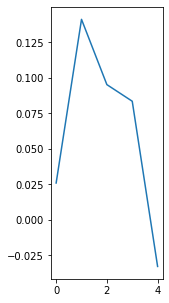

In [ ]:
plt.figure(figsize=(2,5))
plt.plot(A_low_best.get_weights()[0][:,0,0,0])

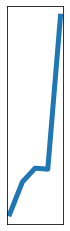

In [ ]:
plt.figure(figsize=(1,4))
plt.plot(A_low_best.get_weights()[4][:,0,0,0], linewidth=5)
plt.tick_params(axis='both', left=False, labelleft=False, bottom=False, labelbottom=False)

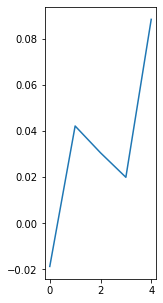

In [ ]:
plt.figure(figsize=(2,5))
plt.plot(A_low_best.get_weights()[6][:,0,0,36])

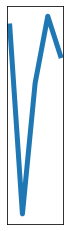

In [ ]:
plt.figure(figsize=(1,4))
plt.plot(A_low_best.get_weights()[6][:,0,0,40], linewidth=5)
plt.tick_params(axis='both', left=False, labelleft=False, bottom=False, labelbottom=False)

In [ ]:
idx = 29

Grad_CAM_A, pred_A, true_A = Build_Grad_CAM(scaled_X_te_A_low, y_te_A_low, A_low_best, 'Conv_1', idx)

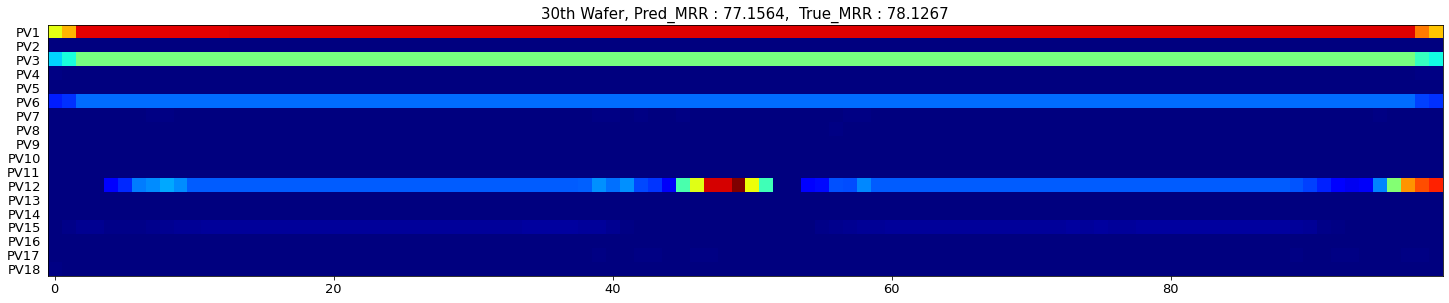

In [ ]:
Plot_Grad_CAM(Grad_CAM_A, pred_A, true_A, idx)

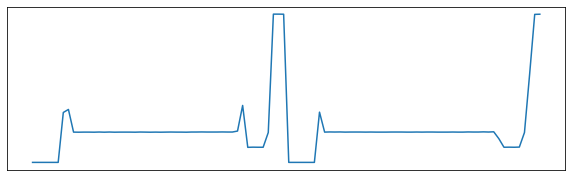

In [ ]:
# 기존 인풋데이터
plt.figure(figsize=(10,3))
plt.plot(scaled_X_te_A_low[29, :, 11])
plt.tick_params(axis='both', left=False, labelleft=False, bottom=False, labelbottom=False)

In [ ]:
Grad_CAM_A.shape

(100, 18)

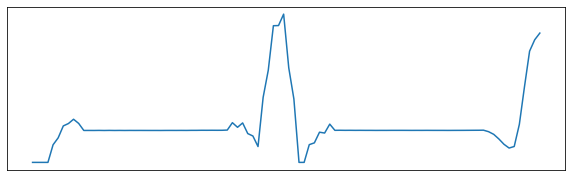

In [ ]:
# 첫번째 커널(합성곱) 통과 후
plt.figure(figsize=(10,3))
plt.plot(Grad_CAM_A[:,11])
plt.tick_params(axis='both', left=False, labelleft=False, bottom=False, labelbottom=False)

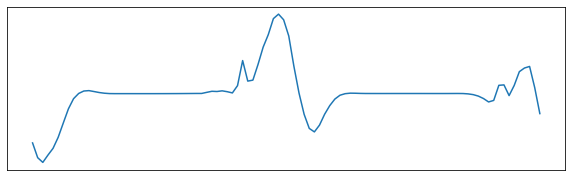

In [ ]:
# 최종 커널(합성곱) 통과 후
plt.figure(figsize=(10,3))
plt.plot(Grad_CAM_A_l[:,11])
plt.tick_params(axis='both', left=False, labelleft=False, bottom=False, labelbottom=False)

# A_low

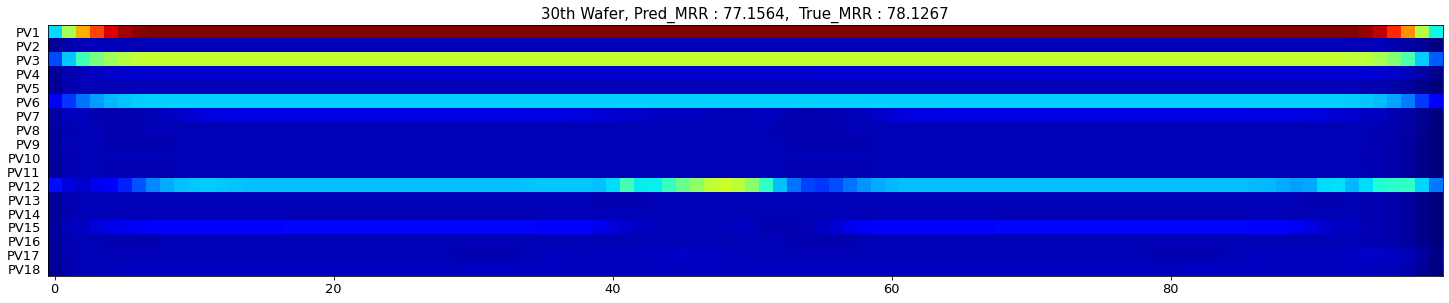

In [ ]:
# 특수 케이스 : 4, 81, 128
idx = 29

Grad_CAM_A_l, pred_A_l, true_A_l = Build_Grad_CAM(scaled_X_te_A_low, y_te_A_low, A_low_best, 'Conv_4', idx)

Plot_Grad_CAM(Grad_CAM_A_l, pred_A_l, true_A_l, idx)

# A_high

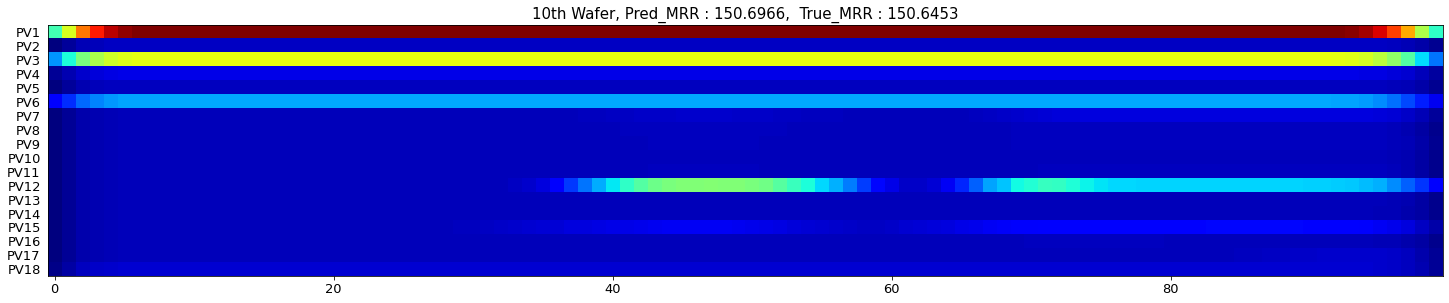

In [7]:
idx=9

Grad_CAM_A_h, pred_A_h, true_A_h = Build_Grad_CAM(scaled_X_te_A_high, y_te_A_high, A_high_best, 'Conv_4', idx)

Plot_Grad_CAM(Grad_CAM_A_h, pred_A_h, true_A_h, idx)

# B

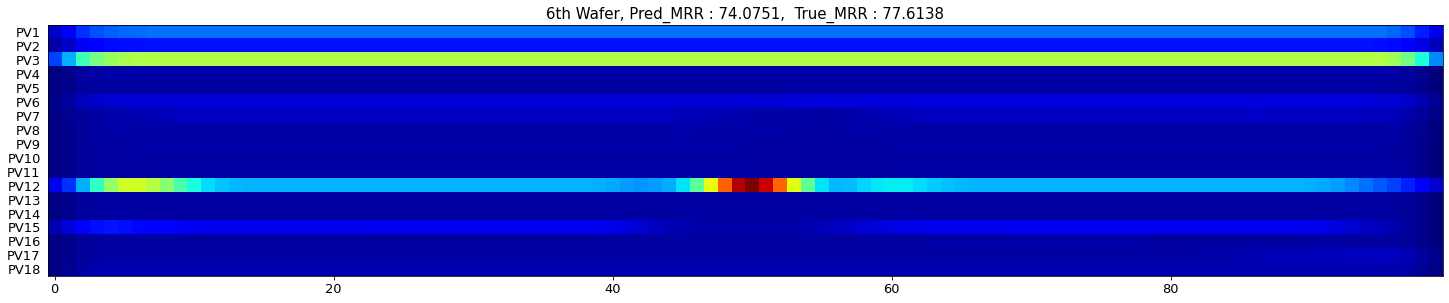

In [ ]:
idx = 5

Grad_CAM_B, pred_B, true_B = Build_Grad_CAM(scaled_X_te_B, y_te_B, B_best, 'Conv_4', idx)

Plot_Grad_CAM(Grad_CAM_B, pred_B, true_B, idx)

In [12]:
def Local_SI(Grad_CAM):
  l = []
  # 전체 구간에 대해 센서별 CAM 값 평균
  for i in range(Grad_CAM.shape[1]):
    l.append(Grad_CAM[:, i].mean())

  l = np.array(l)

  return l

In [ ]:
SI_A_l = Local_SI(Grad_CAM_A_l)

SI_A_h = Local_SI(Grad_CAM_A_h)

SI_B = Local_SI(Grad_CAM_B)

In [ ]:
# Local feature importance
def Plot_Local_SI(SI, data_name, true):
  df = pd.DataFrame({'Sensor Importance':SI}, index=Sensors)
  sorted_df = df.sort_values(by='Sensor Importance')
  ax = sorted_df.plot(kind='barh', figsize=(12,5),
                      title='Sensor Importance of Single Wafer ({}_Group\'s Wafer, True_MRR : {})'.format(data_name, round(true[0],4)), fontsize=12)

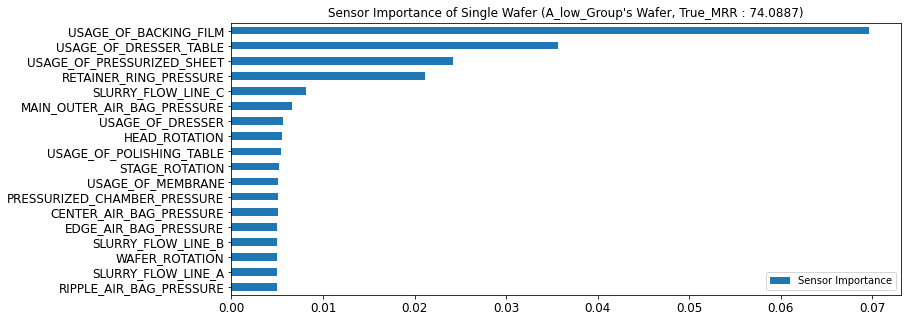

In [ ]:
Plot_Local_SI(SI_A_l, 'A_low', true_A_l)

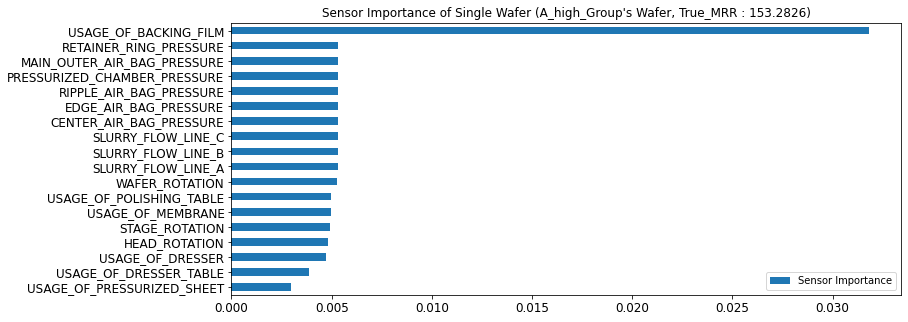

In [ ]:
Plot_Local_SI(SI_A_h, 'A_high', true_A_h)

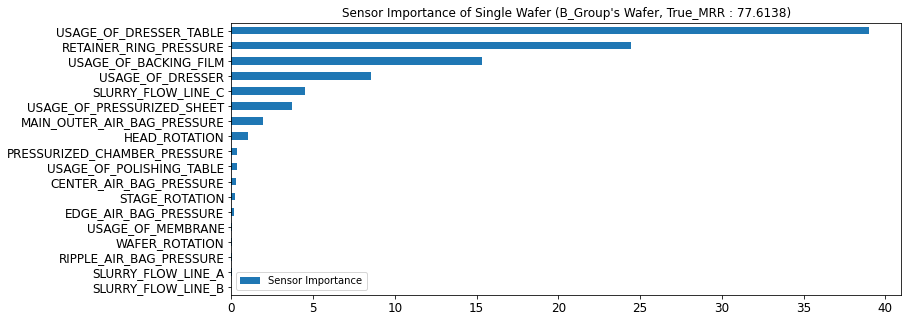

In [ ]:
Plot_Local_SI(SI_B, 'B', true_B)

In [8]:
# PVI 정량화 함수
def Global_SI(inputs, outputs, model, last_conv_layer):
  global_SI = np.zeros((18,))

  for idx in range(inputs.shape[0]):
    grad_CAM, pred, true = Build_Grad_CAM(inputs, outputs, model, last_conv_layer, idx)
    global_SI += Local_SI(grad_CAM)


  return np.array(global_SI)

In [13]:
# Global_SI_A_l = Global_SI(scaled_X_te_A_low, y_te_A_low, A_low_best, 'Conv_4')

Global_SI_A_h = Global_SI(scaled_X_te_A_high, y_te_A_high, A_high_best, 'Conv_4')

# Global_SI_B = Global_SI(scaled_X_te_B, y_te_B, B_best, 'Conv_4')

In [35]:
# PVI 바차트 시각화
# PV_idx = ['PV1', 'PV2', 'PV3', 'PV4', 'PV5', 'PV6', 'PV7', 'PV8', 'PV9', 'PV10', 'PV11', 'PV12', 'PV13', 'PV14', 'PV15', 'PV16', 'PV17', 'PV18']
def Plot_Global_SI(SI, data_name):
  plt.figure(figsize=(12,8))
  df = pd.DataFrame({'Process Sensor Importance':SI[::-1]}, index=Sensors[::-1])
  sorted_df = df.sort_values(by='Process Sensor Importance')
  ax = sorted_df.plot(kind='barh', figsize=(12,5))
                      # title='Process Variable Importance of Recipe({})'.format(data_name), fontsize=12)
  plt.title('Process Sensor Importance in Condition_2', fontsize=20)

<Figure size 864x576 with 0 Axes>

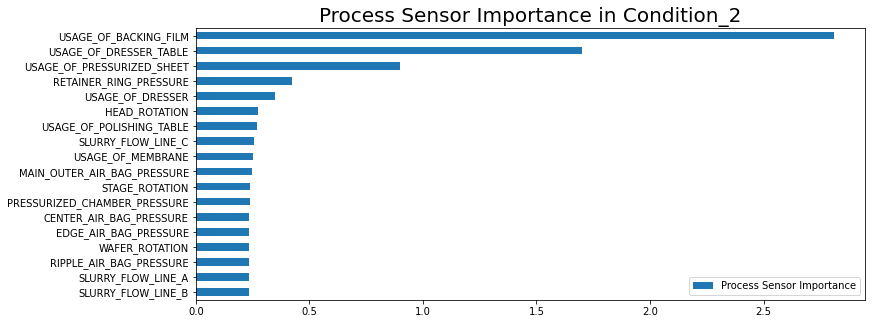

In [36]:
Plot_Global_SI(Global_SI_A_h, 'A_high')

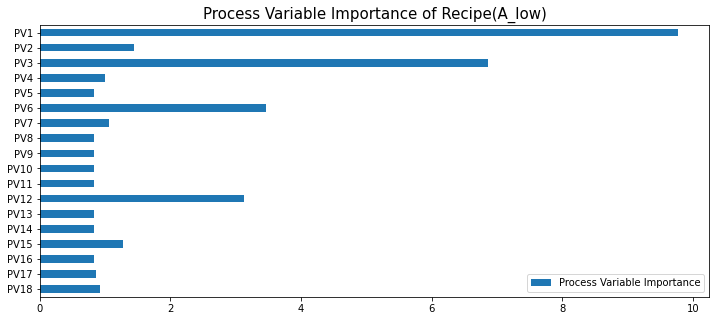

In [ ]:
Plot_Global_SI(Global_SI_A_l, 'A_low')

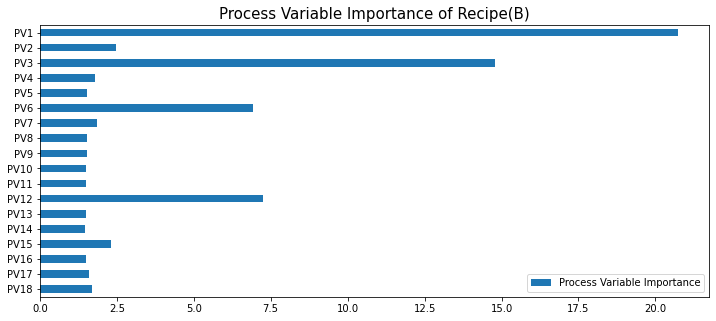

In [ ]:
Plot_Global_SI(Global_SI_B, 'B')

[9.8 1.4 6.9 1.  0.8 3.5 1.1 0.8 0.8 0.8 0.8 3.1 0.8 0.8 1.3 0.8 0.9 0.9]


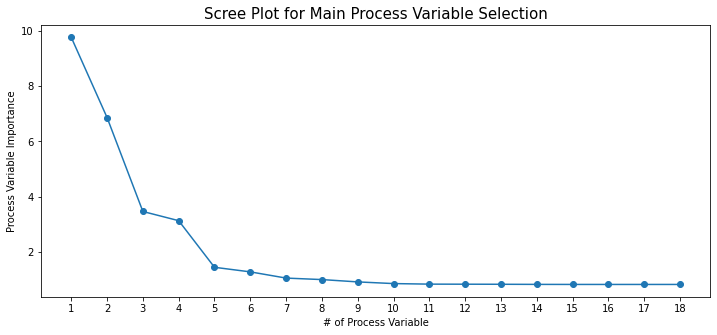

In [ ]:
final_PVI = Global_SI_A_l
# scaled_PVI = (PVI-PVI.min())/(PVI.max()-PVI.min())
# final_PVI = ( scaled_PVI/scaled_PVI.sum() ) * 100

final_PVI = pd.Series(final_PVI)
print(np.round(np.array(final_PVI),1))
sorted_PVI = final_PVI.sort_values(ascending=False, ignore_index=True)

plt.figure(figsize=(12,5))
sorted_PVI.plot(marker='o')
Range=np.arange(0,18)
plt.xticks(Range, Range+1)
plt.title('Scree Plot for Main Process Variable Selection', fontsize=15)
plt.xlabel('# of Process Variable')
plt.ylabel('Process Variable Importance')
plt.show()

In [ ]:
PVI = pd.Series(Global_SI_A_l)

scaled_PVI = (PVI-PVI.min())/(PVI.max()-PVI.min())
SI = ( scaled_PVI/scaled_PVI.sum() ) * 100

print(np.round(np.array(SI),1))
sorted_SI = SI.sort_values(ascending=False,ignore_index=True)

plt.figure(figsize=(12,5))

sorted_SI.cumsum().plot(marker='*', c='grey', linestyle='--')
Range=np.arange(0,18)
plt.xticks(Range, Range+1)
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Scree Plot for Sensor Selection(A_low Group)')
plt.xlabel('# of Process Variable')
plt.ylabel('Cumulative Proportion')
plt.rc('axes', labelsize=15) # fontsize of the tick labels
# plt.rc('ytick', labelsize=13) # fontsize of the tick labels
plt.show()

In [ ]:
sorted_SI.cumsum()

0      41.465799
1      69.474088
2      81.718614
3      92.419351
4      95.298294
5      97.408041
6      98.475180
7      99.292276
8      99.718505
9      99.863737
10     99.916004
11     99.956347
12     99.985500
13     99.996262
14     99.998229
15     99.999125
16    100.000000
17    100.000000
dtype: float64

[49.8  2.2 28.4  0.7  0.4 12.9  0.3  0.1  0.1  0.   0.1  3.7  0.   0.
  0.4  0.   0.1  0.8]


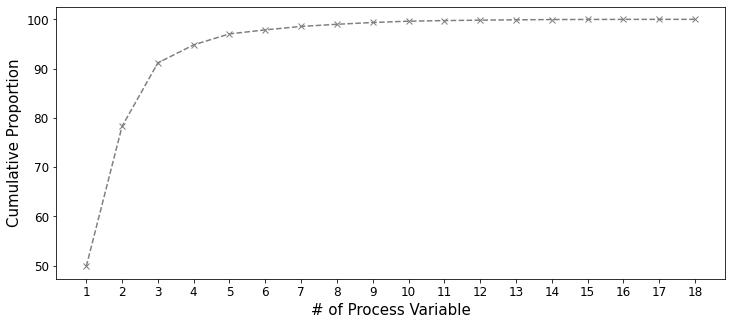

In [ ]:
PVI = pd.Series(Global_SI_A_h)

scaled_PVI = (PVI-PVI.min())/(PVI.max()-PVI.min())
SI = ( scaled_PVI/scaled_PVI.sum() ) * 100

print(np.round(np.array(SI),1))
sorted_SI = SI.sort_values(ascending=False,ignore_index=True)

plt.figure(figsize=(12,5))

sorted_SI.cumsum().plot(marker='x', c='grey', linestyle='--', )
Range=np.arange(0,18)
plt.xticks(Range, Range+1)
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Scree Plot for Sensor Selection(A_low Group)')
plt.xlabel('# of Process Variable')
plt.ylabel('Cumulative Proportion')
plt.rc('axes', labelsize=15) # fontsize of the tick labels
# plt.rc('ytick', labelsize=13) # fontsize of the tick labels
plt.show()

[49.8  2.2 28.4  0.7  0.4 12.9  0.3  0.1  0.1  0.   0.1  3.7  0.   0.
  0.4  0.   0.1  0.8]


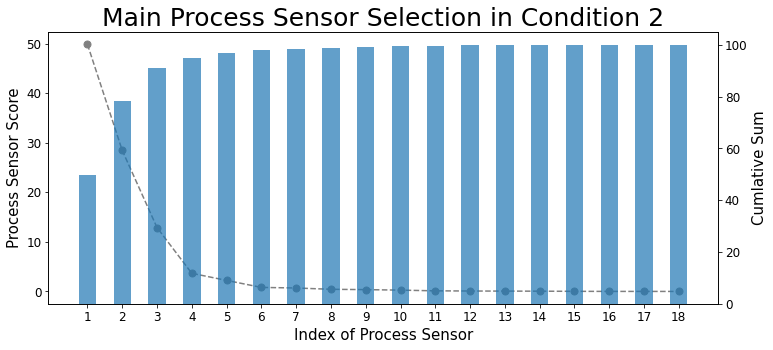

In [81]:
PVI = pd.Series(Global_SI_A_h)

scaled_PVI = (PVI-PVI.min())/(PVI.max()-PVI.min())
SI = (scaled_PVI/scaled_PVI.sum() ) * 100

print(np.round(np.array(SI),1))
sorted_SI = SI.sort_values(ascending=False, ignore_index=True)

fig, ax1 = plt.subplots(figsize=(12,5))
# ax1.figure(figsize=(15,10))
Range=np.arange(1,19)

ax1.plot(Range, sorted_SI, marker='o', c='grey', linestyle='--', markersize=7)
ax1.set_xticks(Range)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel('Index of Process Sensor')
ax1.set_ylabel('Process Sensor Score')

ax2 = ax1.twinx()
ax2.bar(Range, sorted_SI.cumsum(), label='Cum of PSI', width=0.5, alpha=0.7)
ax2.set_xticks(Range)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('Cumlative Sum')

plt.title('Main Process Sensor Selection in Condition 2', fontsize=25)
plt.rc('axes', labelsize=15) # fontsize of the tick labels
plt.show()

[49.8  2.2 28.4  0.7  0.4 12.9  0.3  0.1  0.1  0.   0.1  3.7  0.   0.
  0.4  0.   0.1  0.8]


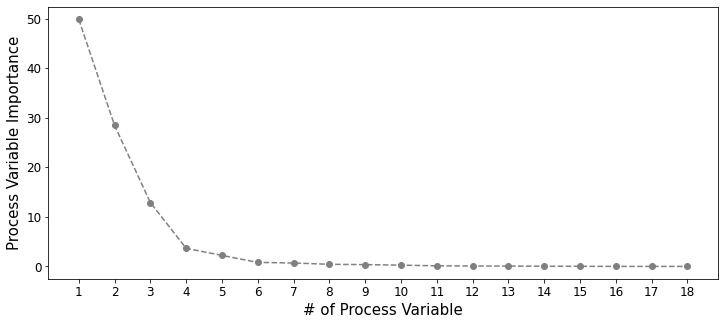

In [ ]:
PVI = Global_SI_A_h
scaled_PVI = (PVI-PVI.min())/(PVI.max()-PVI.min())
final_PVI = ( scaled_PVI/scaled_PVI.sum() ) * 100

final_PVI = pd.Series(final_PVI)
print(np.round(np.array(final_PVI),1))
sorted_PVI = final_PVI.sort_values(ascending=False, ignore_index=True)

plt.figure(figsize=(12,5))
sorted_PVI.plot(marker='o', c='grey', linestyle='--')
Range=np.arange(0,18)
plt.xticks(Range, Range+1)
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Scree Plot for Main Process Variable Selection', fontsize=15)
plt.xlabel('# of Process Variable')
plt.ylabel('Final Variable Importance')
plt.rc('axes', labelsize=15) # fontsize of the tick labels
plt.show()

[41.1  2.1 28.4  0.6  0.1 11.6  0.8  0.1  0.1  0.   0.1 12.3  0.   0.
  1.8  0.   0.2  0.5]


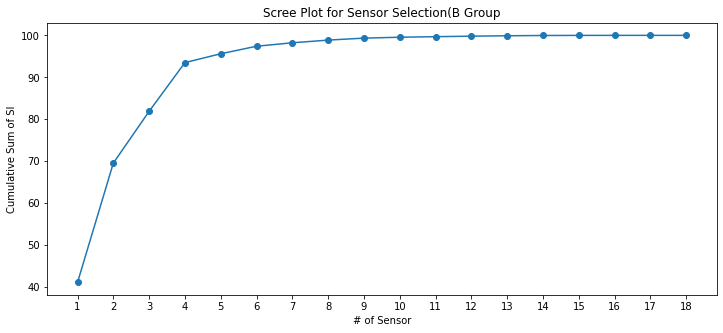

In [ ]:
SI = pd.Series(Global_SI_B)
print(np.round(np.array(SI),1))
sorted_SI = SI.sort_values(ascending=False,ignore_index=True)

plt.figure(figsize=(12,5))

sorted_SI.cumsum().plot(marker='o')
Range=np.arange(0,18)
plt.xticks(Range, Range+1)
plt.title('Scree Plot for Sensor Selection(B Group)')
plt.xlabel('# of Sensor')
plt.ylabel('Cumulative Sum of SI')
plt.show()

# 논문의 주요 컨트리뷰션인 글로벌 센서 중요도의 역할과 의미
- 컨트리뷰션
1. CMP 데이터셋의 시간 정보를 보존한 시계열 형태로 Convolution과 LSTM 을 사용해 시간 종속적인 특징과 시계열 형태에 적합한 연산을 통해 MRR 을 예측함

2. Grad-CAM을 통해 센서중요도를 산출 후 CMP 공정의 MRR 예측 모델 해석 및 진단

- 센서중요도의 역할과 의미
1. MRR 예측에 주요한 영향을 끼친 센서를 확인할 수 있음.

2. CMP공정의 MRR 예측을 위한 주요 센서로 Usage 백킹필름, 드레서테이블, 프레셔리즈드시트와 Pressure 리테이너링이 선정됨. (누적 글로벌 센서 중요도가 90% 이상되게 하는 센서를 선택 시 or 스크리플롯에서 경사가 원만해지기 전 까지의 센서 선택 시)

- 연구 활용 범위
1. MRR 이 아닌 다른 핵심 공정 파라미터(균일도 등)에 대해서도 CMP 센서데이터를 분석하여, 예측과 동시에 해당 공정 파라미터에 주요한 영향을 미치는 센서를 확인하고, 공정 품질 개선을 위해 어떤 센서를 집중적으로 관리할 지에 대한 뱡향성을 제시할 수 있을 것.

# 시간 중요도 코드 모음

In [ ]:
# 모든 시간 간격 또는 모든 센서에 대한 단일 CAM 평균
def Local_TI(Grad_CAM):
  l = []
  for i in range(Grad_CAM.shape[0]):
    l.append(Grad_CAM[i, :].mean())
  
  l= np.array(l)
  TI = (l-l.min())/(l.max()-l.min())
  return TI

TI_A_l = Local_TI(Grad_CAM_A_l)

TI_A_h = Local_TI(Grad_CAM_A_h)

TI_B = Local_TI(Grad_CAM_B)

# 싱글 CAM 시간 중요도를 시각화(x축 : 시간길이 어레이, y축 : 시간 중요도 값, c : grad_CAM )
def Plot_Single_Time_Importance(TI, data_name, idx, true):
  x = range(len(TI))
  y = TI
  
  plt.figure(figsize=(12,5))
  
  plt.scatter(x, y, c=y, cmap='jet')
  plt.plot(x, y)
  plt.colorbar(label='Degree of Importance', orientation='horizontal')
  
  plt.title('Time Importance of ({}_Group\'s {}th Wafer, True_MRR : {})'.format(data_name, idx+1, round(true[0],4)))
  plt.xlabel('Time')
  plt.ylabel('Importance')
  
  plt.show()

Plot_Single_Time_Importance(TI_A_l, "A_low", idx, true_A_l)
Plot_Single_Time_Importance(TI_A_h, "A_high", idx, true_A_h)
Plot_Single_Time_Importance(TI_B, 'B', idx, true_B)


# 단일 센서 시간 영향도를 실제 그래프에 맵핑 시각화(x축 : 시간길이 어레이, y축 : 실제 시계열 센서값, c : grad_CAM )
x = range(scaled_X_te_B.shape[1])
y = scaled_X_te_B[25][:,11]

plt.figure(figsize=(12,5))

plt.scatter(x, y, c=Grad_CAM_1[:,11], cmap='jet')
plt.plot(x, y)
plt.colorbar(label='Degree of Importance', orientation='horizontal')

plt.title('Time Importance of Single Sensor(B Group 26th Wafer, MRR : 82.75)')
plt.xlabel('Time')
plt.ylabel('Sensor value')

plt.show()


# 1D CAM 영향도를 실제 그래프에 맵핑 시각화(x축 : 시간길이 어레이, y축 : 실제 시계열 센서값, c : grad_CAM )
# A그룹 231번째 웨이퍼 mrr 71
x = range(X_test.shape[1])
y = X_test[215]

plt.figure(figsize=(12,5))

plt.scatter(x, y, c=grad_CAM)
plt.plot(x, y)
plt.colorbar(label='Degree of Importance', orientation='horizontal')

plt.title('Time Importance of Sensor(A Group 215th Wafer, MRR : 71.75)')
plt.xlabel('Time')
plt.ylabel('Sensor value')

plt.show()

# 샘플별 CAM에서 각 TI, SI 합계냄(Global CAM 적용 X)
def Global_TI(inputs, outputs, model, last_conv_layer):
  global_TI = np.zeros((100,))

  for idx in range(inputs.shape[0]):
    grad_CAM, pred, true = Build_Grad_CAM(inputs, outputs, model, last_conv_layer, idx)
    global_TI += Local_TI(grad_CAM)

  return np.array(global_TI)


def Plot_Global_Time_Importance(Global_TI, data_name):
  x = range(len(Global_TI))
  y = Global_TI/np.array(Global_TI).max()
  
  plt.figure(figsize=(12,5))
  
  plt.scatter(x, y, c=y, cmap='jet')
  plt.plot(x, y)
  plt.colorbar(label='Degree of Importance', orientation='horizontal')
  
  plt.title('Time Importance of Global CAM ({}_Group)'.format(data_name))
  plt.xlabel('Time')
  plt.ylabel('Importance')
  
  plt.show()

Global_TI_A_h = Global_TI(scaled_X_te_A_high, y_te_A_high, A_high_best, 'Conv_4')
Plot_Global_Time_Importance(Global_TI_A_h, 'A_high')

# 진단 작업

1. 시그널 그래프
2. CAM 히트맵
3. 센서중요도
4. 시간중요도

- 센서중요도를 통해 해당 웨이퍼에 대한 MRR 예측 시 어떤 센서와 구간에서 중요하게 작용했는지 확인하고, MRR이 높을 시와 낮을 시 비교할 만한 샘플 찾아보기


- 높은 MRR을 보이는 샘플에선 백킹필름과 드레서테이블이 순으로 주요하게 작용했고,
- 낮은 MRR을 보이는 샘플에선 드레서테이블과 리테이너링 순으로 주요하게 작용했음을 알 수 있다.

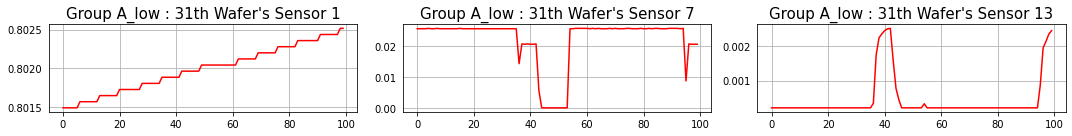

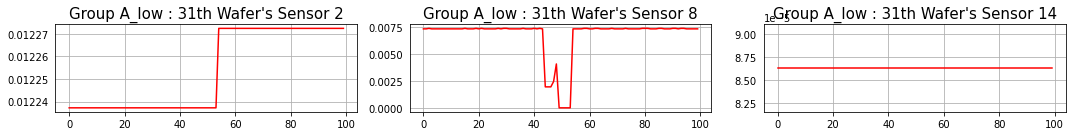

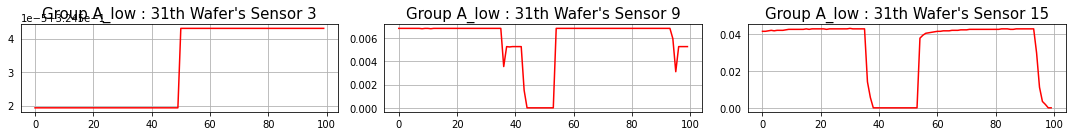

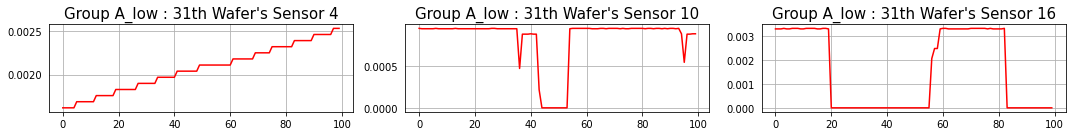

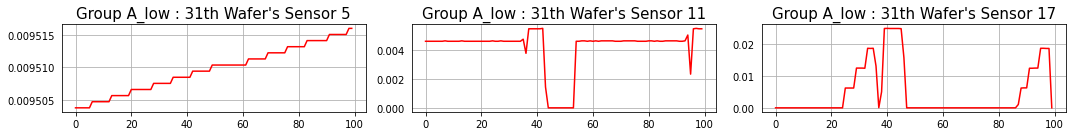

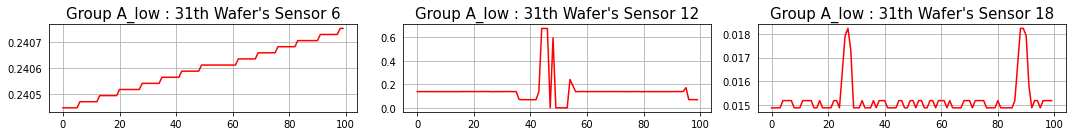

In [ ]:
# A_te resize 후 그래프
idx = 30
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(scaled_X_te_A_high[idx][:,i], color='red')
  axes[0].set_title('Group A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(scaled_X_te_A_high[idx][:,i+6], color='red')
  axes[1].set_title('Group A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(scaled_X_te_A_high[idx][:,i+12], color='red')
  axes[2].set_title('Group A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

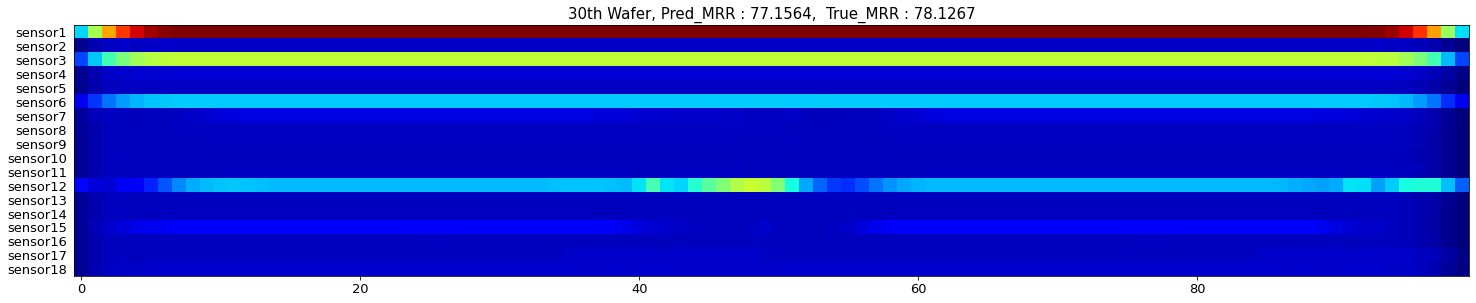

In [ ]:
# 인덱스 29, MRR 예측값 77, 실제값 78 (높은 MRR)
idx = 29

Grad_CAM_A_l, pred_A_l, true_A_l = Build_Grad_CAM(scaled_X_te_A_low, y_te_A_low, A_low_best, 'Conv_4', idx)

Plot_Grad_CAM(Grad_CAM_A_l, pred_A_l, true_A_l, idx)

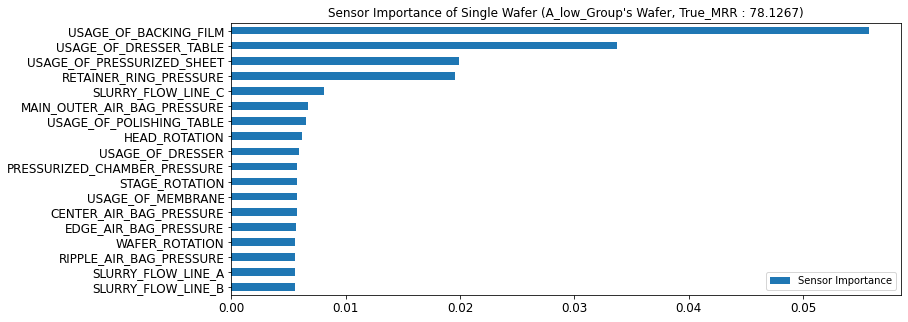

In [ ]:
SI_A_l = Local_SI(Grad_CAM_A_l)

Plot_Local_SI(SI_A_l, 'A_low', true_A_l)

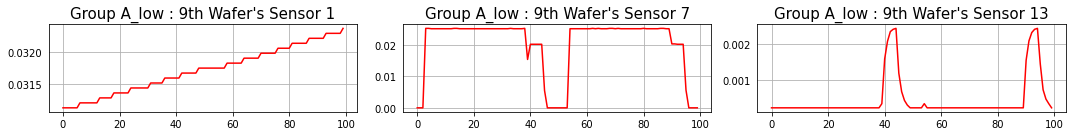

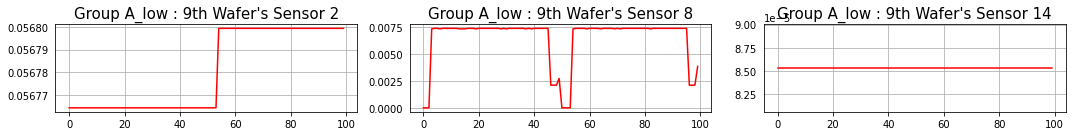

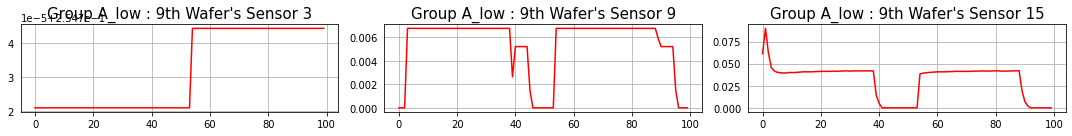

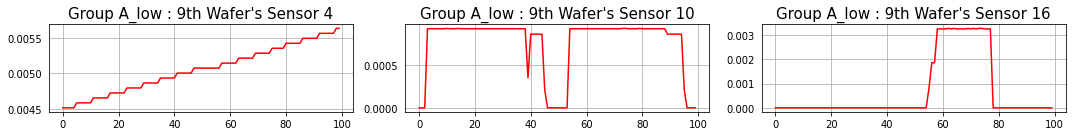

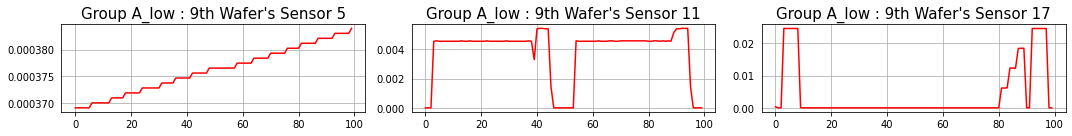

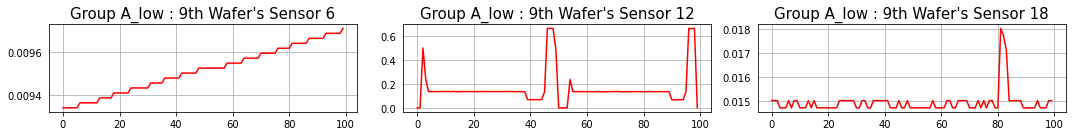

In [ ]:
# A_te resize 후 그래프
idx = 8
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(scaled_X_te_A_low[idx][:,i], color='red')
  axes[0].set_title('Group A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(scaled_X_te_A_low[idx][:,i+6], color='red')
  axes[1].set_title('Group A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(scaled_X_te_A_low[idx][:,i+12], color='red')
  axes[2].set_title('Group A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

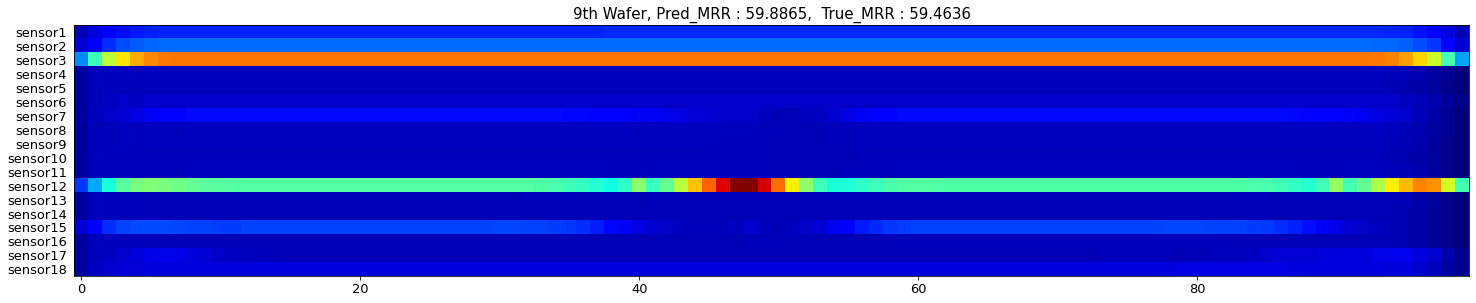

In [ ]:
# 인덱스 8, MRR 예측값 59, 실제값 59 (낮은 MRR)
idx = 8

Grad_CAM_A_l, pred_A_l, true_A_l = Build_Grad_CAM(scaled_X_te_A_low, y_te_A_low, A_low_best, 'Conv_4', idx)

Plot_Grad_CAM(Grad_CAM_A_l, pred_A_l, true_A_l, idx)

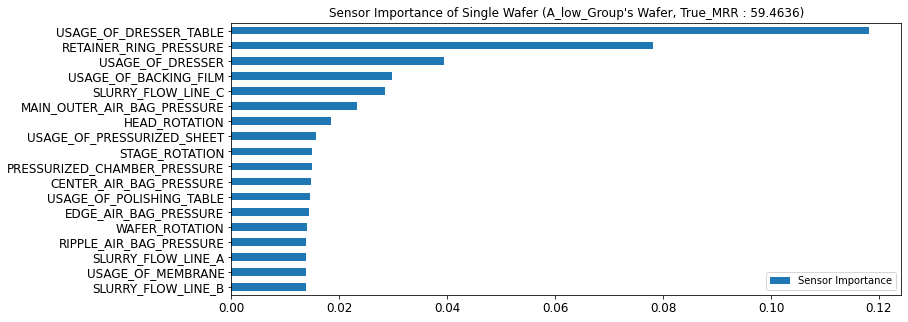

In [ ]:
SI_A_l = Local_SI(Grad_CAM_A_l)

Plot_Local_SI(SI_A_l, 'A_low', true_A_l)

# 분류 작업

In [ ]:
# clf Grad_CAM 생성 코드
def Build_Grad_CAM(inputs, y_test, model, last_conv_layer, idx):
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
  )

  with tf.GradientTape() as tape:
    f_k, y_k = grad_model(inputs)
  # y_k에 대한 A_k의 그래디언트
  grads = tape.gradient(y_k, f_k)
  # GAP로 그래디언트를 가중치화
  weights = tf.reduce_mean(grads, axis=(0,1,2))
  # 배치사이즈 제거로 보려는 인스턴스 선택
  f_k = f_k[idx]
  pred = y_k[idx]
  true = y_test[idx]

  # 맵핑하기 위한 공간 초기화
  grad_cam = np.zeros(dtype=np.float32, shape=f_k.shape[:2])
  
  for k, w in enumerate(weights):
    grad_cam += w * f_k[:, :, k]

  # ReLU에 넣어 positive한 값만 산출
  grad_cam = np.maximum(grad_cam, 0)
  # 정규화
  grad_CAM = grad_cam/grad_cam.max()

  return grad_CAM, pred, true

def Plot_Grad_CAM(cam_output, pred_value, true_value, true_mrr, idx):
  plt.figure(figsize=(25,12))
  plt.title('{}th Wafer, '.format(idx+1)+'Pred_Class : '+str(round(pred_value.numpy()[0], 4))+',  True_Class : '+str(round(true_value[0], 4))+', True_MRR : '+str(round(true_mrr[idx][0], 4)))
  plt.imshow(tf.reshape(np.array(cam_output).T, (18, 100)), cmap='jet')
  y_ticks = ['sensor1','sensor2','sensor3','sensor4','sensor5','sensor6',
           'sensor7','sensor8','sensor9','sensor10','sensor11','sensor12',
           'sensor13','sensor14','sensor15','sensor16','sensor17','sensor18']
  plt.yticks(np.arange(0, 18), y_ticks)
  plt.show()

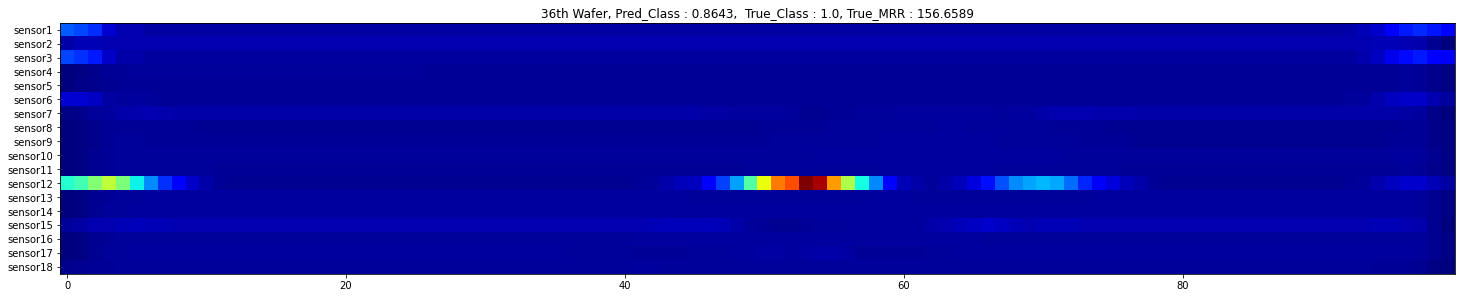

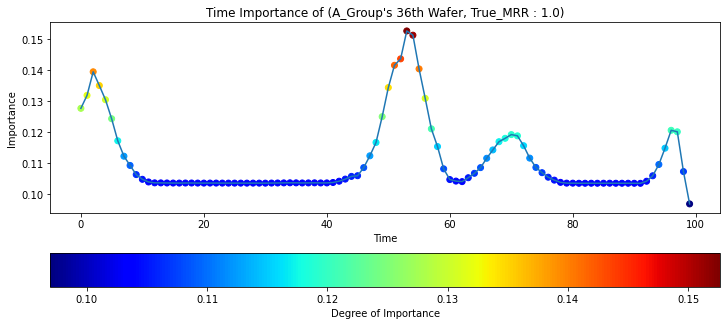

In [ ]:
# MRR low 틀린거 154
idx =35

Grad_CAM_A, pred_A, true_A = Build_Grad_CAM(scaled_X_te_A, y_te_A_class, A_clf_best, 'Conv_4', idx)

Plot_Grad_CAM(Grad_CAM_A, pred_A, true_A, y_te_A, idx)

TI_A = Local_time_importances(Grad_CAM_A)
Plot_Single_Time_Importance(TI_A, "A", idx, true_A)

In [ ]:
# Conv 1D 단일 센서의 주요 구간 파악
def Build_Grad_CAM_1D(inputs, model, last_conv_layer, idx):
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
  )

  with tf.GradientTape() as tape:
    A_k, y_k = grad_model(inputs)
  # y_k에 대한 A_k의 그래디언트
  grads = tape.gradient(y_k, A_k)
  # GAP로 그래디언트를 가중치화
  weights = tf.reduce_mean(grads, axis=(0,1))
  # 배치사이즈 제거로 보려는 인스턴스 선택
  A_k = A_k[idx]
  pred = y_k[idx]
  true = y_test[idx]

  #맵핑하기 위한 공간 초기화
  grad_cam = np.zeros(dtype=np.float32, shape=A_k.shape[:1])
  
  for k, w in enumerate(weights):
    grad_cam += w * A_k[:, k]

  # ReLU에 넣어 positive한 값만 산출
  grad_cam = np.maximum(grad_cam, 0)
  #정규화
  grad_CAM = grad_cam/grad_cam.max()

  return grad_CAM.reshape(-1,1), pred, true


def Plot_Grad_CAM_1D(cam_output, pred_value, true_value):
  # 타이틀에 모델별 MSE랑 모델이름 출력 추가
  plt.figure(figsize=(35,25))
  plt.title('pred : '+str(pred_value)+'  true : '+str(true_value))
  plt.imshow(tf.reshape(np.array(cam_output).T, (1, 100)))
  # plt.yticks(np.arange(0, 18))
  plt.show()

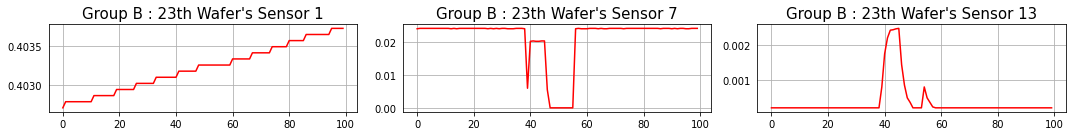

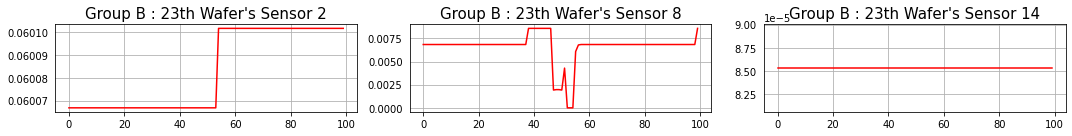

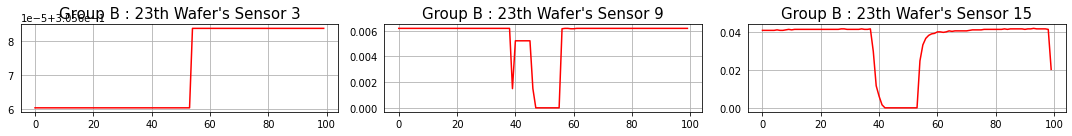

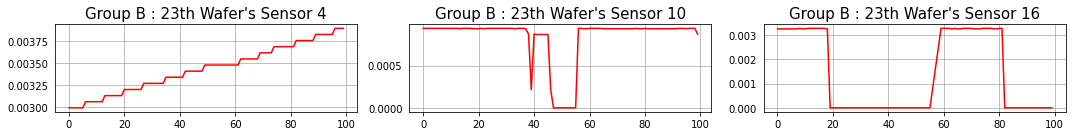

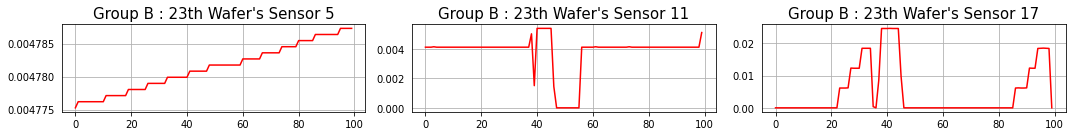

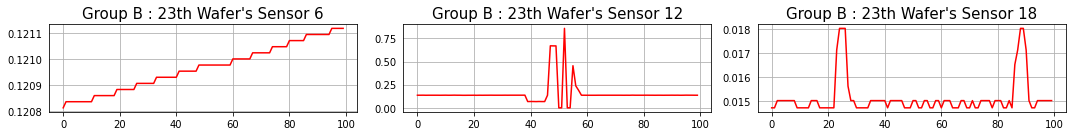

In [ ]:
# A_te resize 후 그래프
idx = 22
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(scaled_X_te_A[idx][:,i], color='red')
  axes[0].set_title('Group B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(scaled_X_te_A[idx][:,i+6], color='red')
  axes[1].set_title('Group B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(scaled_X_te_A[idx][:,i+12], color='red')
  axes[2].set_title('Group B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()